# Programming for Data Analytics (CA_TWO) - GroupA

Group Memebers

*   Chirag Sushil Gupta - 10623123
*   Chukwuebuka Uwaoma - 10621864
*   Dipanshu



In [3]:
# Import necesarry libraries
import tweepy
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import mysql.connector
import datetime
import re
import pypyodbc
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from wordcloud import WordCloud
import matplotlib.pyplot as plt

### API configuration

In [4]:
# Load dotenv and read secret keys and tokens
load_dotenv()
api_key = os.getenv('api_key')
api_secret_key = os.getenv('api_secret_key')
access_token = os.getenv('access_token')
access_token_secret = os.getenv('access_token_secret')

In [5]:
# Connect to twitter using tweepy API and stored tokens
auth = tweepy.OAuthHandler(api_key,api_secret_key)
auth.set_access_token(access_token,access_token_secret)
api = tweepy.API(auth)

### Data Extraction

In [7]:
# Pulls tweets based on search query and geocode location
tweetlist = []
geocode="53.1424,-7.6921,300km"   # Ireland's geocode
filter =  '-filter:retweets AND -filter:replies'
query = '(housing) OR (housing crisis) OR (rent)'
today = datetime.date.today()

# adds tweets to a dataframe
column_names = ["id", "created_at", "username", "tweet", "retweet_count", "favorite_count", "user_location"]
df = pd.DataFrame(columns=column_names)

# Pulling tweets of a week from today's date
for i in range(6,-2,-1):
    # Looping through each day
    until = today - datetime.timedelta(days = i)
    date = until.strftime("%Y-%m-%d")

    # Retrieving the tweets using api by passing the necessary parameters
    for tweet in tweepy.Cursor(api.search_tweets, q=query+filter, geocode=geocode, lang='en', tweet_mode="extended", until = date).items(5):
        new_row = pd.Series({
        "id": tweet.id, 
        "created_at":tweet.created_at,
        "username": tweet.user.screen_name, 
        "tweet": tweet.full_text, 
        "retweet_count": tweet.retweet_count, 
        "favorite_count": tweet.favorite_count,
        "user_location":tweet.user.location,
        })
        
        # get the index of the last row
        last_row_index = len(df)
        # add the new row to the DataFrame using .iloc[]
        df.loc[last_row_index] = new_row
df.head()

,id,created_at,username,tweet,retweet_count,favorite_count,user_location
0,1647000579590217729,2023-04-14 22:15:12+00:00,GrahamPatchell,I can’t wait for my child to sit down at 4 yea...,0,4,"Naas, Ireland"
1,1646999889652359168,2023-04-14 22:12:28+00:00,SteveDonnelly95,Words cannot do justice to how proud I am of t...,0,1,Clanabogan
2,1646996793391996929,2023-04-14 22:00:09+00:00,Independent_ie,‘I’m facing eviction in May. I won’t be able t...,107,617,Dublin
3,1646985682014072833,2023-04-14 21:16:00+00:00,thomas_tkl,Watch Biden's visit be the next excuse for mis...,0,2,"Ireland, Dublin"
4,1646979425718747136,2023-04-14 20:51:09+00:00,DeptHousingIRL,We have schemes like this commencing on sites ...,0,2,"Dublin, Ireland"


### Data Preprocessing

In [8]:
# Dimension of the dataset
df.shape

(40, 7)

In [9]:
# Checking for duplicate values in the dataset
sum(df.duplicated())

0

In [13]:
# Checking for null values in the dataset
(df.isnull().sum())

id                0
created_at        0
username          0
tweet             0
retweet_count     0
favorite_count    0
user_location     0
dtype: int64

In [15]:
# Formatting the date to dd/mm/YYYY format
def formatDate(timestamp):
    # As the timestamp retrieved from the api is already in DatetimeIndex form, simply converting it to desired format
    # and finally, transforming it to datetime again
    formatted_date = timestamp.strftime("%Y-%m-%d")
    formatted_date = datetime.datetime.strptime(formatted_date, "%Y-%m-%d")
    return formatted_date

# Getting only the words and numbers from the tweet that contains links, special symbols, emojis, etc.
def cleanTweet(tweet):
    # Converting the string to lowercase and replacing the ' with blank
    removed_apostrophe = tweet.lower().replace("'","")
    # Using regex pattern to replace the links, <html> tags and &amp; symbol (seen frequently in the tweets) with blank
    removed_links_tags_frequentsymbol = re.sub("(https?://\S+)|(<[\w]+>)|(&amp;)","",removed_apostrophe)
    # This regex pattern returns a list that contains all the words and numbers in the tweet
    cleaned_tweet = re.findall("([a-z0-9]+)", removed_links_tags_frequentsymbol)
    cleaned_tweet = " ".join(cleaned_tweet)
    return cleaned_tweet

# Applying respective functions to both columns in the dataset
df["created_at"] = df["created_at"].apply(formatDate)
df["cleaned_tweet"] = df["tweet"].apply(cleanTweet)
df.head()

,id,created_at,username,tweet,retweet_count,favorite_count,user_location,cleaned_tweet
0,1647000579590217729,2023-04-14,GrahamPatchell,I can’t wait for my child to sit down at 4 yea...,0,4,"Naas, Ireland",i can t wait for my child to sit down at 4 yea...
1,1646999889652359168,2023-04-14,SteveDonnelly95,Words cannot do justice to how proud I am of t...,0,1,Clanabogan,words cannot do justice to how proud i am of t...
2,1646996793391996929,2023-04-14,Independent_ie,‘I’m facing eviction in May. I won’t be able t...,107,617,Dublin,i m facing eviction in may i won t be able to ...
3,1646985682014072833,2023-04-14,thomas_tkl,Watch Biden's visit be the next excuse for mis...,0,2,"Ireland, Dublin",watch bidens visit be the next excuse for miss...
4,1646979425718747136,2023-04-14,DeptHousingIRL,We have schemes like this commencing on sites ...,0,2,"Dublin, Ireland",we have schemes like this commencing on sites ...


In [207]:
max_retweets = df[df["retweet_count"] == max(df.retweet_count)].reset_index(drop=True)
max_retweets

,id,created_at,username,tweet,retweet_count,favorite_count,user_location,cleaned_tweet
0,1646996793391996929,2023-04-14,Independent_ie,‘I’m facing eviction in May. I won’t be able t...,107,616,Dublin,i m facing eviction in may i won t be able to ...


In [208]:
print(max_retweets.tweet[0])

‘I’m facing eviction in May. I won’t be able to teach’: Teacher (31) on €52k can’t afford to rent or buy https://t.co/JGHIiIVtai https://t.co/gRY5uLssyp


In [209]:
df.loc[df.username == max_retweets.username[0]]

,id,created_at,username,tweet,retweet_count,favorite_count,user_location,cleaned_tweet
2,1646996793391996929,2023-04-14,Independent_ie,‘I’m facing eviction in May. I won’t be able t...,107,616,Dublin,i m facing eviction in may i won t be able to ...
53,1648816242776481792,2023-04-19,Independent_ie,Investment giant buys apartment blocks in Dubl...,12,25,Dublin,investment giant buys apartment blocks in dubl...


In [210]:
max_likes = df[df["favorite_count"] == max(df.favorite_count)].reset_index(drop=True)
max_likes

,id,created_at,username,tweet,retweet_count,favorite_count,user_location,cleaned_tweet
0,1646996793391996929,2023-04-14,Independent_ie,‘I’m facing eviction in May. I won’t be able t...,107,616,Dublin,i m facing eviction in may i won t be able to ...


In [211]:
print(max_likes.tweet[0])

‘I’m facing eviction in May. I won’t be able to teach’: Teacher (31) on €52k can’t afford to rent or buy https://t.co/JGHIiIVtai https://t.co/gRY5uLssyp


In [212]:
df.loc[df.username == max_retweets.username[0]]

,id,created_at,username,tweet,retweet_count,favorite_count,user_location,cleaned_tweet
2,1646996793391996929,2023-04-14,Independent_ie,‘I’m facing eviction in May. I won’t be able t...,107,616,Dublin,i m facing eviction in may i won t be able to ...
53,1648816242776481792,2023-04-19,Independent_ie,Investment giant buys apartment blocks in Dubl...,12,25,Dublin,investment giant buys apartment blocks in dubl...


In [160]:
dummy = df.groupby(pd.Grouper(key='created_at', freq='D')).size()
dummy

created_at
2023-04-14    10
2023-04-15    10
2023-04-16    10
2023-04-17    10
2023-04-18    10
2023-04-19    10
2023-04-20    10
2023-04-21    10
Freq: D, dtype: int64

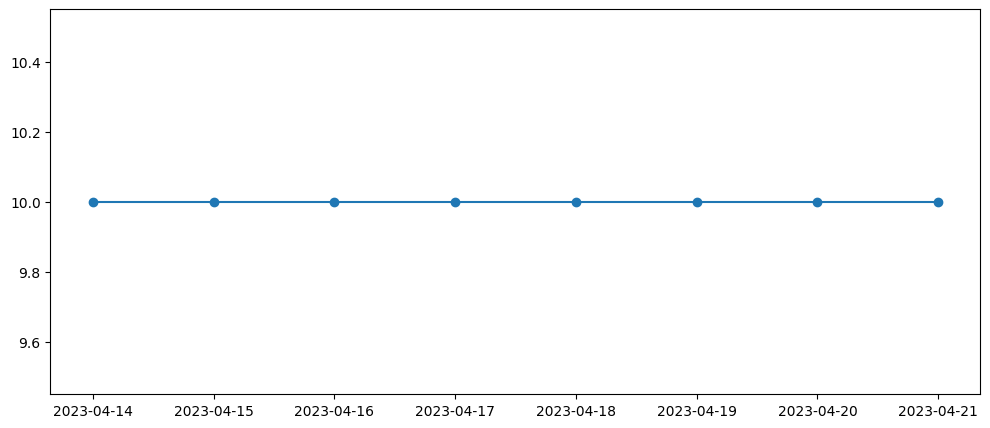

In [161]:
plt.figure(figsize=(12,5))
plt.plot(dummy,"-o")
plt.show()

In [389]:
connection = mysql.connector.connect(host='localhost',
                                         database='ca',
                                         user='root',
                                         password='toor')

In [390]:
# SQL query to create a table and inserting the columns name in it.
mySql_insert_query = 'CREATE TABLE if not exists api (id int(22) primary key ,created_at DATE,username varchar(255),tweet TEXT(50000),retweet_count int(255),favorite_count int(255),user_location varchar(255));'

In [391]:
# Create a cursor object "cursor" to execute MySQL queries with.
# The "buffered=True" parameter sets up the cursor to buffer the results, which can be useful for large queries.
cursor = connection.cursor(buffered=True)

# Use the cursor's "execute()" method to execute the MySQL query specified in the "mySql_insert_query" variable.
cursor.execute(mySql_insert_query)

# Commit the changes made to the MySQL database using the connection's "commit()" method.
connection.commit()

In [392]:
# Use a for loop to iterate over the rows of the Pandas DataFrame "df".

for i in range(df.shape[0]):
    # Initialize an empty string "s" to store the column names.
    s=""
    # Use another for loop to iterate over the columns of the DataFrame and concatenate the column names to the "s" string.
    for j in df.columns:
        s=s+j+","
    # Remove the last comma from the "s" string.
    s=s[:-1]

    # Initialize an empty string "t" to store the values in the current row.
    t=""
    # Use another for loop to iterate over the columns of the DataFrame and concatenate the values to the "t" string, 
    # converting them to strings and enclosing them in quotes.
    for k in df.columns:
        t=t+"'"+str(df[k].iloc[i])+"',"
    # Remove the last comma from the "t" string.
    t=t[:-1]
    
    # Create a MySQL query "command" to insert the current row into the "api" table.
    # The column names are specified by the "s" string, and the values are specified by the "t" string.
    command="INSERT INTO api ("+s+") VALUES ("+t+");"
    # Use a try-except block to execute the MySQL query using the cursor's "execute()" method.
    # If an error occurs, ignore it and continue to the next row.
    try:
        cursor.execute(command)
    except:
        pass

# Commit the changes made to the MySQL database using the connection's "commit()" method.
connection.commit()


In [393]:
# Data retrieve from DB and insert into pd df

# Define a MySQL query "sql_query" to select all columns from the "api" table.
sql_query = "SELECT * FROM api"

# Use the cursor's "execute()" method to execute the MySQL query.
cursor.execute(sql_query)

# Use the cursor's "fetchall()" method to fetch all the rows returned by the MySQL query.
result = cursor.fetchall()

# Convert the fetched rows into a Pandas DataFrame "data" using the "pd.DataFrame()" function.
data=pd.DataFrame(result)

# Rename the columns of the DataFrame using the "columns" attribute of the DataFrame.
data.columns=["id", "created_at", "username", "tweet", "retweet_count", "favorite_count", "user_location"]

# Print the DataFrame "data" to the console.
data



,id,created_at,username,tweet,retweet_count,favorite_count,user_location
0,1647634340082335750,16/04/2023,UrbanArchCon,6 collective housing interventions that rethin...,0,0,"South Dublin, Ireland"
1,1647635355229724672,16/04/2023,luke_oriordan,minister for housing must explain department u...,0,2,"Glasnevin, Dublin"
2,1647641119440744456,16/04/2023,RoryHearneGaffs,irelands housing crisis generation catastrophe...,35,117,Dublin
3,1647655780730929152,16/04/2023,oceanclub,quite a gulf between this anon fine gael tds s...,2,8,"Dublin, Ireland"
4,1647656641074982916,16/04/2023,john_e_horan,really enjoyed this and feels true ireland now...,0,0,"South Dublin, Ireland"
...,...,...,...,...,...,...,...
120,1648971509707292673,20/04/2023,louthcoco,affordable housing expressions of interest lou...,0,0,Co Louth Ireland
121,1648971686090362880,20/04/2023,louthcoco,you can now access the cro c naithe grant with...,0,0,Co Louth Ireland
122,1648971766528704512,20/04/2023,SouthernStarIRL,west cork caravan parks are reporting a big ri...,0,1,"West Cork, Ireland"
123,1648972506563244032,20/04/2023,brianfeeney007,ive said it before and ill say it again robert...,0,0,"Blackrock, Dublin"


In [394]:
# Download necessary resources from NLTK
# tokenize
nltk.download('punkt')

# Tokenize the "tweet" column
data['tokenized_tweet'] = data['tweet'].apply(lambda x: word_tokenize(x))
# print(data.head())
# data.to_csv('updated_data.csv', index=False)
data.loc[:, 'tokenized_tweet'].to_csv('tokenized_tweets.csv', index=False)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [395]:
# lematize
df = pd.read_csv('tokenized_tweets.csv')

nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

print(df.columns)
print(df['tokenized_tweet'])

df['lemmatized_tweets'] = df['tokenized_tweet'].apply(lemmatize_text)

df.to_csv('lemi_tweet.csv', index=False)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Index(['tokenized_tweet'], dtype='object')
0      ['6', 'collective', 'housing', 'interventions'...
1      ['minister', 'for', 'housing', 'must', 'explai...
2      ['irelands', 'housing', 'crisis', 'generation'...
3      ['quite', 'a', 'gulf', 'between', 'this', 'ano...
4      ['really', 'enjoyed', 'this', 'and', 'feels', ...
                             ...                        
120    ['affordable', 'housing', 'expressions', 'of',...
121    ['you', 'can', 'now', 'access', 'the', 'cro', ...
122    ['west', 'cork', 'caravan', 'parks', 'are', 'r...
123    ['ive', 'said', 'it', 'before', 'and', 'ill', ...
124    ['not', 'one', 'modular', 'home', 'ready', 'fo...
Name: tokenized_tweet, Length: 125, dtype: object


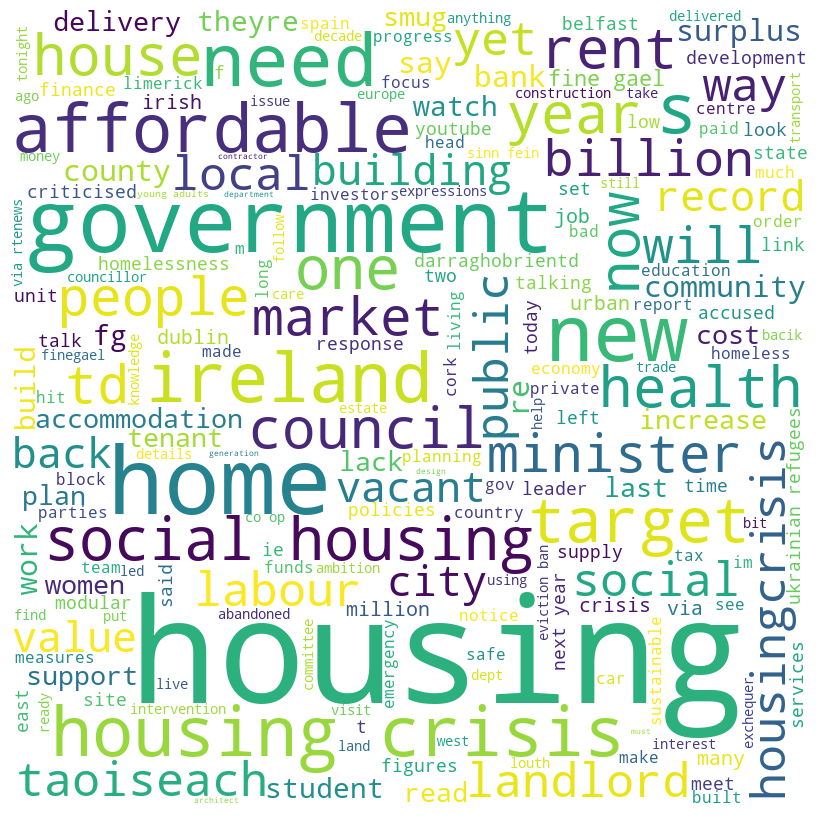

In [396]:
# wordcloud
# Read in the lemmatized tweets data
df = pd.read_csv('lemi_tweet.csv')

# Concatenate all tweets into a single string
all_tweets = ' '.join(df['lemmatized_tweets'])

# Generate a word cloud from the concatenated string
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(all_tweets)

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

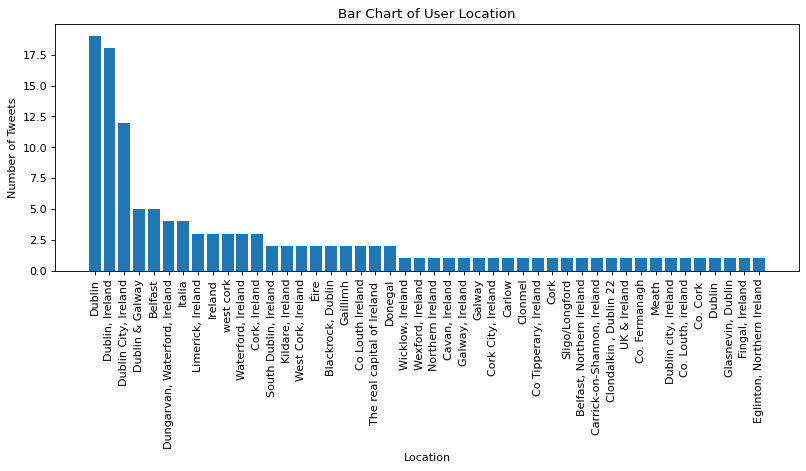

In [397]:
location_counts = data['user_location'].value_counts()
from matplotlib.pyplot import figure

figure(figsize=(12, 4), dpi=80)

plt.bar(location_counts.index, location_counts.values)
plt.title('Bar Chart of User Location')
plt.xlabel('Location')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=90)
plt.show()